# Fase 1 - SVM con ProfilingUD (in-genre classification)
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo basata solo su informazioni linguistiche non lessicali estratte utilizzando il sistema Profiling-UD. Riportare i seguenti risultati:
- valutazione del sistema con un processo di 5-fold cross validation condotto sul training
set;
- valutazione del sistema sul test set ufficiale del task;
- elenco delle 15 feature più importanti per la classificazione

Dal task GxG Evalita 2018:

"Given a (collection of) text(s) from a specific genre, the gender of the author has to be predicted. The task is cast as a binary classification task, with gender represented as F (female) or M (male). Gender prediction will be done in two ways: 

1. **using a model which has been trained on the same genre**
2. using a model which has been trained on anything but that genre."

In questo file utilizzeremo un modello allenato sullo stesso genere su cui poi verrà testato.

In [1]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier

## Preparazione del dataset

In [2]:
gold_file_path = "../../data/dataset_originale/gold/test_CH.gold"
profiling_output_path = '../../data/profiling_output/children/linguistic_profile.csv' # risultati analisi linguistica dei testi del genere scelto

In [3]:
# Caricamento del CSV delle feature linguistiche
def load_dataset(src_path):
    features_names = None # conterrà i nomi delle feature
    documents_info = [] # è un vettore che consiste nella prima colonna del file csv: children/training#66#children#F.conllu di tutti i doc
    features = []

    # row[0] è ['Filename', 'n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'ttr_lemma_chunks_100', 'ttr_lemma_chunks_200', 'ttr_form_chunks_100', ...
    # row[1] è ['children/training#66#children#F.conllu', '21', '396', '18.857142857142858', '4.227528089887641', '0.68', ...
    # row[2] è ['children/test#133#children#unknown.conllu', '13', '328', '25.23076923076923', '3.99672131147541', '0.52', ...
    # etc ...
    
    with open(src_path, 'r') as src_file:
        csv_reader = csv.reader(src_file, delimiter='\t')
        for row in csv_reader:
            if features_names is None: # la prima riga del csv contiene 'Filename' e tutti i nomi delle features (la prima volta che entro nel ciclo ho feature_name ancora inizializzato a None, e quindi uso questa condizione per iniziare a popolare l'array
                features_names = row[1:] # estraggo le feature, ovvero salto la prima colonna dove è contenuto il nome del file
            else:
                documents_info.append(row[0]) # il primo elemento di ogni riga contiene il nome del file children/training#66#children#F.conllu dove sono codificati il genere, lo split e i velori numerici delle feature
                features.append([float(el) for el in row[1:]]) # dal secondo elemento in poi ci sono i nomi delle feature perché il primo è il nome del file
    return features_names, documents_info, features    

In [4]:
features_names, documents_info, features = load_dataset(profiling_output_path)
# features_name è la prima riga del file csv (quella con i nomi delle features)
# documents_info è l'elenco dei nomi dei file con l'#.conllu
# features sono i veri valori di TUTTE le feature (di tutti i documenti)

In [5]:
print("Numero features: " + str(len(features_names)))
print('\nLista prime dieci features:')
print(features_names[:10])

Numero features: 138

Lista prime dieci features:
['n_sentences', 'n_tokens', 'tokens_per_sent', 'char_per_tok', 'ttr_lemma_chunks_100', 'ttr_lemma_chunks_200', 'ttr_form_chunks_100', 'ttr_form_chunks_200', 'upos_dist_ADJ', 'upos_dist_ADP']


In [6]:
print('Primo documento:')
print(f'Document info: {documents_info[0]}')
print('Secondo documento:')
print(f'Document info: {documents_info[1]}')
print('Nono documento:')
print(f'Document info: {documents_info[9]}')
print('\n')
# print("Features names: " + str(features_names[:10]))
print(f'Features: {features[0][:10]}')

Primo documento:
Document info: children/training#66#children#F.conllu
Secondo documento:
Document info: children/test#133#children#unknown.conllu
Nono documento:
Document info: children/training#92#children#F.conllu


Features: [26.0, 451.0, 17.346153846153847, 4.549222797927461, 0.67, 0.575, 0.81, 0.69, 3.3259423503325944, 8.425720620842572]


### Creazione lista delle classi (labels)

In [7]:
# Estraggo lo split (training/test), l'ID del testo (66), il genre (children) e il genere (F/M)

document_info = documents_info[0] # consideriamo il primo documento profiling_input/training#859#SPORTS#20-29#M.conllu

print('Document info:', document_info)

document_info = document_info.split('/')[1]
print('Document info senza cartella:', document_info)

document_info = document_info.split('.')[0]
print('Document info senza estensione:', document_info)

splitted_document_info = document_info.split('#')
print('Split su #:', splitted_document_info)

label = splitted_document_info[2]
print('Label:', label)

Document info: children/training#66#children#F.conllu
Document info senza cartella: training#66#children#F.conllu
Document info senza estensione: training#66#children#F
Split su #: ['training', '66', 'children', 'F']
Label: children


In [8]:
#per capire la cella dopo
'''
for doc_info in documents_info:
    doc_info = doc_info.split('/')[1]
    # doc_info = training#66#children#F.conllu
    doc_info = doc_info[0:-len('.conllu')]
    # doc_info = training#66#children#F
    splitted_doc_info = doc_info.split('#')
    # splitted_doc_info = ['training', '66', 'children', 'F']
    genre = splitted_doc_info[2]
    # genre = children
    gender = splitted_doc_info[3]
    # gender = F
'''

"\nfor doc_info in documents_info:\n    doc_info = doc_info.split('/')[1]\n    # doc_info = training#66#children#F.conllu\n    doc_info = doc_info[0:-len('.conllu')]\n    # doc_info = training#66#children#F\n    splitted_doc_info = doc_info.split('#')\n    # splitted_doc_info = ['training', '66', 'children', 'F']\n    genre = splitted_doc_info[2]\n    # genre = children\n    gender = splitted_doc_info[3]\n    # gender = F\n"

In [9]:
# Creazione delle etichette dai nomi dei file
def create_label_list(documents_info):
    labels = []
    
    for doc_info in documents_info:
        doc_info = doc_info.split('/')[1]
        # doc_info = training#66#children#F.conllu
        doc_info = doc_info[0:-len('.conllu')]
        # doc_info = training#66#children#F
        splitted_doc_info = doc_info.split('#')
        # splitted_doc_info = ['training', '66', 'children', 'F']
        genre = splitted_doc_info[2]
        # genre = children
        gender = splitted_doc_info[3]
        # gender = F
        
        labels.append(gender)
    return labels

In [10]:
labels = create_label_list(documents_info)

In [11]:
def train_test_split(documents_info, features, labels):
    train_features = []
    test_features = []
    train_labels = []
    test_filenames = []  # Salviamo i nomi dei file di test

    for idx in range(len(documents_info)):  # Iteriamo sugli indici invece che su zip() come faceva Luca
    #for doc_info, doc_features, doc_label in zip(documents_info, features, labels): #Altra versione for idx in range(len(documents_info))

        doc_info = documents_info[idx]
        doc_features = features[idx]
        doc_label = labels[idx]
    
        if 'training' in doc_info:
            train_features.append(doc_features)                # train_features.append(documents_info[idx])
            train_labels.append(doc_label)
        else: # if 'test' in file_name
            test_features.append(doc_features)
            test_filenames.append(doc_info)
            
    return train_features, train_labels, test_features, test_filenames

In [12]:
labels[:10]

['F', 'unknown', 'M', 'F', 'unknown', 'F', 'F', 'M', 'unknown', 'F']

### Divisione tra training e test set

In [13]:
train_features, train_labels, test_features, test_filenames = train_test_split(documents_info, features, labels)

print('Documenti training set:', len(train_features), len(train_labels))
print('Documenti test set:', len(test_features), len(test_filenames))

Documenti training set: 200 200
Documenti test set: 199 199


## 5-fold cross validation su training set

In [14]:
y_train = np.asarray(train_labels)
splitter = KFold(n_splits=5, random_state=42, shuffle=True)
folds = list(splitter.split(train_features))  # Dividiamo sui dati originali, non normalizzati

In [15]:
print("\n=== Dimensioni dei Fold ===")
for i in range(len(folds)):
    print(f"Fold {i+1}: Training set = {len(folds[i][0])}, Test set = {len(folds[i][1])}")
# Il dataset di training viene diviso con la regola dell'80/20 come vediamo dalla stampa


=== Dimensioni dei Fold ===
Fold 1: Training set = 160, Test set = 40
Fold 2: Training set = 160, Test set = 40
Fold 3: Training set = 160, Test set = 40
Fold 4: Training set = 160, Test set = 40
Fold 5: Training set = 160, Test set = 40


In [16]:
# Liste in cui salviamo le predizioni
all_y_true = []
all_y_pred = []

In [17]:
for i in range(len(folds)):
    train_ids, test_ids = folds[i]

    fold_X_train = np.array(train_features)[train_ids]
    fold_y_train = y_train[train_ids]
    fold_X_test = np.array(train_features)[test_ids]
    fold_y_test = y_train[test_ids]

    # Normalizzazione dentro ogni fold (solo con i dati di training del fold)
    scaler = MinMaxScaler()
    fold_X_train = scaler.fit_transform(fold_X_train)
    fold_X_test = scaler.transform(fold_X_test)

    kfold_svc = LinearSVC(dual=False)
    kfold_svc.fit(fold_X_train, fold_y_train)
    fold_y_pred = kfold_svc.predict(fold_X_test)

    fold_accuracy = accuracy_score(fold_y_test, fold_y_pred)

    # Baseline con Dummy Classifier
    dummy_clf = DummyClassifier(strategy="most_frequent")
    dummy_clf.fit(fold_X_train, fold_y_train)
    dummy_score = dummy_clf.score(fold_X_test, fold_y_test)

    all_y_true += fold_y_test.tolist()
    all_y_pred += fold_y_pred.tolist()

    print(f"Accuracy fold {i+1}: {fold_accuracy} \t baseline dummy: {dummy_score}")

Accuracy fold 1: 0.625 	 baseline dummy: 0.475
Accuracy fold 2: 0.425 	 baseline dummy: 0.425
Accuracy fold 3: 0.45 	 baseline dummy: 0.475
Accuracy fold 4: 0.525 	 baseline dummy: 0.4
Accuracy fold 5: 0.5 	 baseline dummy: 0.425



=== Risultati della 5-Fold Cross Validation ===
              precision    recall  f1-score   support

           F       0.50      0.53      0.52       100
           M       0.51      0.48      0.49       100

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.50       200



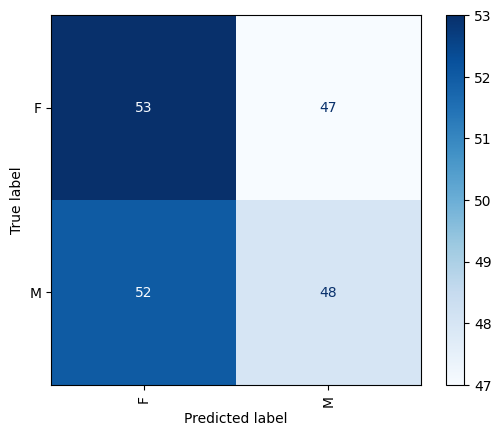

In [18]:
# Report finale della cross-validation
print("\n=== Risultati della 5-Fold Cross Validation ===")
print(classification_report(all_y_true, all_y_pred, zero_division=0))
ConfusionMatrixDisplay.from_predictions(all_y_true, all_y_pred, xticks_rotation='vertical', cmap='Blues')

## Addestramento sul training set completo e 

### Normalizzazione

In [19]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_features) # Normalizziamo tutto il training set
X_test = scaler.transform(test_features) # train e test devono usare la stessa normalizzazione, quindi salvo come variabile lo scaler e uso solo transform sul test

### Training del modello su tutto il training set

In [20]:
svc = LinearSVC(dual=False)
svc.fit(X_train, train_labels)

LinearSVC(dual=False)

### Test del modello su tutto il test set

In [21]:
# Predizioni sul test set
test_predictions = svc.predict(X_test)

In [22]:
# Confronto con Dummy Classifier sul test set
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, train_labels)
dummy_predictions = dummy_clf.predict(X_test)

In [23]:
# Estrazione degli ID dai file di test
test_ids = [name.split("#")[1] for name in test_filenames]  # Estrai solo l'ID numerico

### Valutazione del modello con il gold set

In [24]:
# Caricamento del file GOLD e conversione in DataFrame
gold_df = pd.read_csv(gold_file_path, delimiter="\t", names=["ID", "True_Gender"])

In [25]:
# Creiamo il df con le predizioni
df_output = pd.DataFrame({"ID": test_ids, "Predicted_Gender": test_predictions})
dummy_output = pd.DataFrame({"ID": test_ids, "Dummy_Gender": dummy_predictions})


=== Risultati sul Test Set ===
Accuratezza SVM: 0.5729
Accuratezza Dummy: 0.5025
              precision    recall  f1-score   support

           F       0.56      0.69      0.62       100
           M       0.59      0.45      0.51        99

    accuracy                           0.57       199
   macro avg       0.58      0.57      0.57       199
weighted avg       0.58      0.57      0.57       199



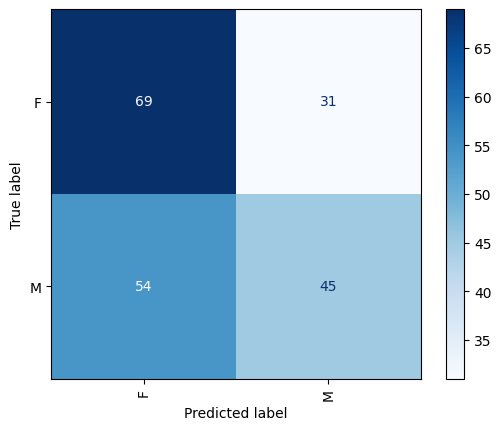

In [27]:
# Convertiamo entrambe le colonne "ID" in stringa per evitare errori di merge
df_output["ID"] = df_output["ID"].astype(str)
gold_df["ID"] = gold_df["ID"].astype(str)

# Uniamo le predizioni con il gold standard
merged_df = pd.merge(df_output, gold_df, on="ID")
merged_dummy_df = pd.merge(dummy_output, gold_df, on="ID")

### Metriche di valutazione

# Calcoliamo le prestazioni
accuracy = accuracy_score(merged_df["True_Gender"], merged_df["Predicted_Gender"])
dummy_accuracy = accuracy_score(merged_dummy_df["True_Gender"], merged_dummy_df["Dummy_Gender"])

print("\n=== Risultati sul Test Set ===")
print(f"Accuratezza SVM: {accuracy:.4f}")
print(f"Accuratezza Dummy: {dummy_accuracy:.4f}")
print(classification_report(merged_df["True_Gender"], merged_df["Predicted_Gender"]))
# support è il numero di campioni reali presenti per ciascuna classe

# Matrice di Confusione
ConfusionMatrixDisplay.from_predictions(
    merged_df["True_Gender"], merged_df["Predicted_Gender"], xticks_rotation='vertical', cmap='Blues');

## 15 features più importanti

In [ ]:
coefs = svc.coef_[0]  # Coefficienti della SVM
feature_importances = {feature: abs(coef) for feature, coef in zip(features_names, coefs)}  # Valori assoluti
sorted_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)[:15]  # Primi 15

In [ ]:
# Stampiamo le feature più importanti
print("\n=== Top 15 Feature più importanti ===")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

In [ ]:
# Plot delle feature più importanti
features, importances = zip(*sorted_features)
plt.figure(figsize=(10, 5))
plt.barh(features, importances, align="center")
plt.xlabel("Importanza")
plt.title("Top 15 Feature più importanti")
plt.gca().invert_yaxis()
plt.show()